# In this notebook aims to build a CNN model to perform a multiclass classification of malwares from the malimg (malware image) dataset.
This dataset directly comes from the paper Malware Images: Visualization and Automatic Classification

In [ ]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# Preprocessing

In [2]:
path_root = "../input/malimg/malimg_dataset/train"

In [3]:
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)

Found 7459 images belonging to 25 classes.


In [4]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [5]:
imgs, labels = next(batches)

In [6]:
imgs.shape

(7459, 64, 64, 3)

In [7]:
labels.shape

(7459, 25)

### Sample images from our dataset

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

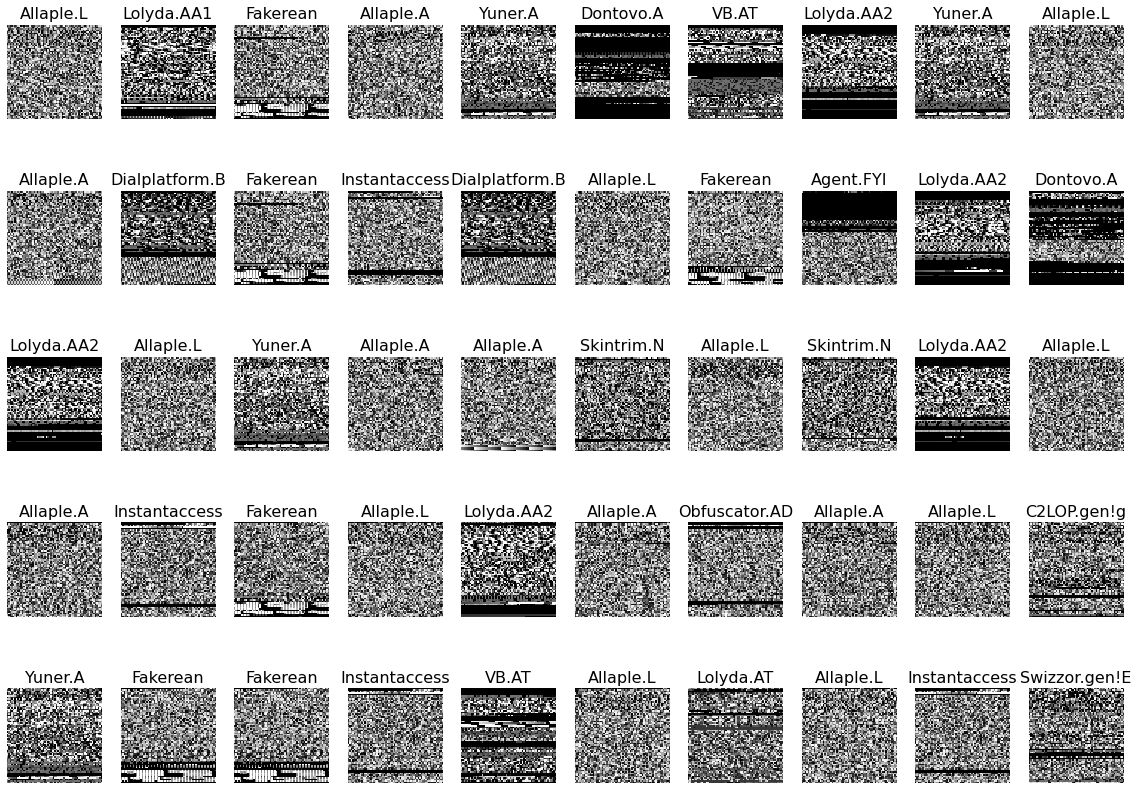

In [9]:
plots(imgs, titles = labels)

In [10]:
classes = batches.class_indices.keys()

In [11]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

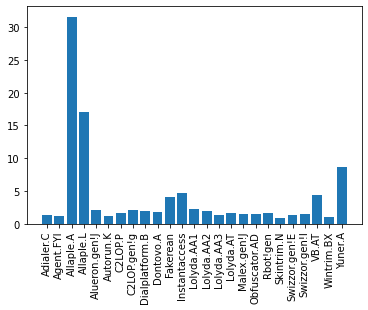

In [12]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

### We can see that our dataset is quite unbalanced : a lot of Malwares belong to class 2 : Allaple.A and class 3 : Allaple.L 

# Train and Test split

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [14]:
X_train.shape

(5221, 64, 64, 3)

In [15]:
X_test.shape

(2238, 64, 64, 3)

# Convolutional Neural Network Model
We will now build our CNN model using Keras. This model will have the following layers :

- Convolutional Layer : 30 filters, (3 * 3) kernel size
- Max Pooling Layer : (2 * 2) pool size
- Convolutional Layer : 15 filters, (3 * 3) kernel size
- Max Pooling Layer : (2 * 2) pool size
- DropOut Layer : Dropping 25% of neurons.
Flatten Layer
- Dense/Fully Connected Layer : 128 Neurons, Relu activation function
- DropOut Layer : Dropping 50% of neurons.
- Dense/Fully Connected Layer : 50 Neurons, Softmax activation function
- Dense/Fully Connected Layer : num_class Neurons, Softmax activation function
- Input shape : 64 * 64 * 3

In [16]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization

In [17]:
num_classes = 25

In [18]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [19]:
Malware_model = malware_model()

In [20]:
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 30)        840       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2940)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [21]:
y_train.shape

(5221, 25)

In [22]:
y_train_new = np.argmax(y_train, axis=1)

In [23]:
y_train_new

array([24, 24,  3, ...,  3,  2,  2])

In [24]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_train_new),y=y_train_new)

In [25]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=22)

Epoch 1/22
164/164 [==============================] - 8s 8ms/step - loss: 1.8845 - accuracy: 0.4411 - val_loss: 0.9339 - val_accuracy: 0.6979
Epoch 2/22
164/164 [==============================] - 1s 5ms/step - loss: 0.8771 - accuracy: 0.7150 - val_loss: 0.4869 - val_accuracy: 0.8834
Epoch 3/22
164/164 [==============================] - 1s 5ms/step - loss: 0.5626 - accuracy: 0.8345 - val_loss: 0.2931 - val_accuracy: 0.9169
Epoch 4/22
164/164 [==============================] - 1s 5ms/step - loss: 0.4069 - accuracy: 0.8784 - val_loss: 0.2170 - val_accuracy: 0.9366
Epoch 5/22
164/164 [==============================] - 1s 5ms/step - loss: 0.3187 - accuracy: 0.9008 - val_loss: 0.1946 - val_accuracy: 0.9397
Epoch 6/22
164/164 [==============================] - 1s 5ms/step - loss: 0.2656 - accuracy: 0.9178 - val_loss: 0.1558 - val_accuracy: 0.9562
Epoch 7/22
164/164 [==============================] - 1s 5ms/step - loss: 0.2316 - accuracy: 0.9263 - val_loss: 0.1487 - val_accuracy: 0.9526
Epoch 

In [26]:
scores = Malware_model.evaluate(X_test, y_test)

70/70 [==============================] - 0s 4ms/step - loss: 0.1327 - accuracy: 0.9651


In [27]:
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.9651474356651306


In [28]:
#Lets anlysis our result:
import numpy as np
import pandas as pd

In [29]:
y_pred = Malware_model.predict(X_test[[0]])

In [30]:
y_pred

array([[1.6177306e-14, 7.3750216e-18, 1.0000000e+00, 7.1814747e-14,
        1.0472627e-13, 1.6198781e-12, 6.0071526e-09, 7.5579657e-15,
        6.4587550e-15, 7.5093169e-21, 7.6283516e-15, 2.6699915e-14,
        2.0852161e-12, 6.4928172e-16, 2.6342459e-12, 3.8720818e-11,
        1.4531383e-08, 5.2126717e-15, 1.3399810e-16, 8.4715018e-14,
        4.1482835e-16, 6.0612587e-16, 9.8880366e-13, 1.1968748e-12,
        2.2651217e-12]], dtype=float32)

In [31]:
y_test2 = np.argmax(y_test)

In [32]:
print(y_test2)

2


In [33]:
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

In [34]:
save_model(Malware_model,'malware.h5')

In [35]:
model2=load_model('./malware.h5')

In [36]:
model2.evaluate(X_test,y_test)

70/70 [==============================] - 0s 3ms/step - loss: 0.1327 - accuracy: 0.9651


[0.13272033631801605, 0.9651474356651306]